# Part - 1 Reading the text - Exploaring, Cleaning, Creating TF-IDF

### Importing modules which we are gonna use here

In [2]:
import pandas as pd
import os
import operator
import pyscope
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import re
import sys
from urllib.parse import urlparse

from sklearn.feature_extraction.text import TfidfVectorizer
from pywsd.utils import lemmatize_sentence
from nltk.stem import PorterStemmer, WordNetLemmatizer

from wordcloud import WordCloud

import gensim
from gensim.models.phrases import Phrases, Phraser

from sklearn.manifold import TSNE

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

### Loading Data And Processing The Text

Currently we load a data from text file which was downloaded loacally from cosmos. We collected *Query, Count, Snippets, URL, Total SRPVS and RowNumber*. As of now we then combine top 5 snippets for each unique query and then consider that as at the representation of the query.

In [2]:
data = pd.read_table('C:/Projects/Query/Top5Snippets_24_07.txt', names=('Query', 'Count', 'Snippet', 'Url', 'Total_SRPVS','RowNumber'), 
                     delimiter = "\t")

data = data.iloc[: , [0,2,3]]
#display(data)
print("Dimensions of data : " + str(data.shape))

# Remove duplicated snippets
data = data.drop_duplicates('Snippet')

# Drop Null rows
data = data[~data['Snippet'].isnull()]

# Keep snippets with length at least of 140
# data = data[(data.Snippet.map(len) > 140)]

# Replacing the Query with Https:// with Url 
data['Query'] = np.where(data['Query'].str.contains("https") == True, data['Url'], data['Query'])

print("Dimensions of data after removing NULL : " + str(data.shape))



C:\Users\MOSHA\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dimensions of data : (2439152, 3)
Dimensions of data after removing NULL : (2216761, 3)


Sometimes the query is the domain address itself. Below we try to capture only the domain name form the complete URL. We did use this one of our trials but as of now we are not using it. 

In [155]:
# Extracting the domian from the URL
# url = 'https://www.frontrunneroutfitters.com/en/za/front-runner-slimline-ii-full-rack-foot-rail-w-table-openings-suzuki-jimny.htmlhttps://bkshare.com/download-kis-2017-lic-keys-kis-2017-mien-phi/'
# def getDomain(url):
#     return(urlparse(url).netloc)
    
# def find(string):
#     # findall() has been used 
#     # with valid conditions for urls in string
#     url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+][!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
#     return url

In [179]:
# for index, row in data.iterrows():
#     url = data.ix[index, "Query"]
#     if find(url):
#         #print(url)
#         if urlparse(url).netloc != "" :
#             data.ix[index, "Query"] = getDomain(url)
            
# data.Query = data.Query.apply(lambda x: x.strip())         

17°58'8.84"N, 	1	As a Junior (2016-17): Appeared in 25 games for the Ravens including 19 starts...Ranked second on the team in scoring with a career-high 9.0 points per game while ...	http://athletics.franklinpierce.edu/sports/wbkb/2017-18/bios/thacker_jemma_9ji9	5
1900 planning permission"
Aikido Siauliai	1	EDUARDAS, Šiauliai “It was very great to stay here. ... I got to know new people, new things in Aikido and glanced into yoga and meditation.	http://www.dodzo.lt/	4
Aikido Siauliai
comparer les données de deux colonnes EXCEL	1	Bonsoir, Voici mon pb, j'ai 2 colonnes avec des infos que j'aimerais comparer (si les info dans la 1er sont présente dans la 2ème). J'ai essayer avec la formule ...	http://www.tomsguide.fr/forum/id-552470/comparer-contenu-colonnes-excel.html	3
comparer les données de deux colonnes EXCEL
(http://goto/myit
(http://goto/myit
(http://goto/myit
(http://www.thejcbgroup.co.uk/seat/used-cars/8786468-seat-ibiza-1.0-tsi-95ps-fr-s-s-5-door/)
(http://www.thejc

### Checking the distribution of length of snippets 
First we will check for the outliers and then check the distrubtion of len of snippets by ignoring the outliers.

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

(array([ 82695.,  86925., 125540., 204776., 390840., 773106., 131157.,
         14041.,   9963.,  11608.]),
 array([103. , 115.4, 127.8, 140.2, 152.6, 165. , 177.4, 189.8, 202.2,
        214.6, 227. ]),
 <a list of 10 Patch objects>)

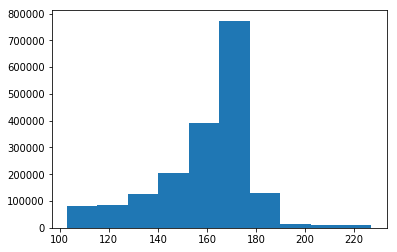

In [4]:
filtered = data[~is_outlier(data.Snippet.map(len))]
plt.hist(filtered.Snippet.map(len))

### Combinging Snippents
We would now take each query and combine the top 5 snippets to form a bigger document. We then display the results and check the dimensions of this new dataset.

In [5]:
data = filtered.groupby('Query').agg({'Snippet':lambda x:', '.join(map(str, x))
                        })
data.reset_index(level=0, inplace=True)


print("\nDisplaying the results of top 3 snippets\n")
display(data.head(3))

print(f"Created a dataset of {data.shape[0]} X {data.shape[1]}")


Displaying the results of top 3 snippets



,Query,Snippet
0,www.komfort.com,Glass doors for glazed partition systems. Avai...
1,   € @ ÑÕML...,4 à ä ø& Ðl à ä ô p:2Kle ñ a˜Í2ô:þ(9 \ Ù QÙ u²...
2,Spy...,... PlayStation® 4 Pro and the family of Xbox...


Created a dataset of 476637 X 2


### Text Processing

We will now clean the text. In text, we will clean both the snippets and queries. As some queries are just figures or non english text. Following are the things which we intend to remove:

1. We remove Non-Ascii character
2. We substitute some short forms into proper forms
3. We remove digits - both decimal and non decimal
4. We remove any alphanumeric character and the underscore
5. We remove matches any non-whitespace character
6. We remove punctuations


In [6]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

In [7]:
Snippet = data.loc[:, "Snippet"]
Snippet = Snippet.apply(lambda x : x.lower())
Snippet = Snippet.apply(lambda x: _removeNonAscii(x))
Snippet = Snippet.apply(lambda x: re.sub(r"what's", "what is ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'s", " is ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'ve", " have ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"can't", "cannot ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"n't", " not ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"i'm", "i am ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'re", " are ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'d", " would ", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'ll", " will ", x))
Snippet = Snippet.apply(lambda x: re.sub(r'\W+',' ', x ))
Snippet = Snippet.apply(lambda x: re.sub(r'\s+', ' ', x))
Snippet = Snippet.apply(lambda x: re.sub(r"\\", "", x))
Snippet = Snippet.apply(lambda x: re.sub(r"\'", "", x))  
Snippet = Snippet.apply(lambda x: re.sub(r"\"", "", x))
Snippet = Snippet.apply(lambda x: re.sub(r'\d+', '', x))
Snippet = Snippet.apply(lambda x: re.sub(r'_', ' ', x))


In [330]:
Query = data.loc[:, "Query"]

Query = Query.apply(lambda x : x.lower())
Query = Query.apply(lambda x: _removeNonAscii(x))
Query = Query.apply(lambda x: re.sub(r"what's", "what is ", x))
Query = Query.apply(lambda x: re.sub(r"\'s", " is ", x))
Query = Query.apply(lambda x: re.sub(r"\'ve", " have ", x))
Query = Query.apply(lambda x: re.sub(r"can't", "cannot ", x))
Query = Query.apply(lambda x: re.sub(r"n't", " not ", x))
Query = Query.apply(lambda x: re.sub(r"i'm", "i am ", x))
Query = Query.apply(lambda x: re.sub(r"\'re", " are ", x))
Query = Query.apply(lambda x: re.sub(r"\'d", " would ", x))
Query = Query.apply(lambda x: re.sub(r"\'ll", " will ", x))
Query = Query.apply(lambda x: re.sub(r'\W+',' ', x ))
Query = Query.apply(lambda x: re.sub(r'\s+', ' ', x))
Query = Query.apply(lambda x: re.sub(r"\\", "", x))
Query = Query.apply(lambda x: re.sub(r"\'", "", x))  
Query = Query.apply(lambda x: re.sub(r"\"", "", x))
Query = Query.apply(lambda x: re.sub(r'\d+', '', x))
Query = Query.apply(lambda x: re.sub(r'_', ' ', x))


### Lemmeatizing the words

We use wordnet from nltk module to do this and then we remove the words which are of length less than 3. Following this all the stopwords are removed. We have collected the stop words list in the separate python script which we will be calling here.

**Note**: Stop words for now are stored in a comma separated file at the below metioned path.



In [331]:
stop_words_list = pd.read_csv(r'C:/Projects/Query/Scripts/Stop_words.csv', header = None, encoding='latin-1')
stop_words_list = list(stop_words_list[0])

print("Stopword list has %d entries" % len(stop_words_list) )

Stopword list has 614 entries


In [332]:
wnl = WordNetLemmatizer()
Snippet = Snippet.apply(lambda x: " ".join([wnl.lemmatize(i) for i in x.split()]))

# port = PorterStemmer()
# Snippet = Snippet.apply(lambda x: " ".join([port.stem(i) for i in x.split()]))

Snippet = Snippet.apply(lambda x: re.sub(r'\b\w{1,2}\b', ' ', x))

Snippet = Snippet.apply(lambda x:  ' '.join([word for word in x.split() if word not in (stop_words_list)]))

In [333]:
Query = Query.apply(lambda x: " ".join([wnl.lemmatize(i) for i in x.split()]))

# port = PorterStemmer()
# Query = Query.apply(lambda x: " ".join([port.stem(i) for i in x.split()]))

Query = Query.apply(lambda x: re.sub(r'\b\w{1,2}\b', ' ', x))


In [334]:
data = pd.concat([Query, Snippet], axis=1)
print("listing first few lines of the data after the text processing.\n")
display(data.head())

listing first few lines of the data after the text processing.



,Query,Snippet
0,,fffft ccc obj endobj obj stream tmo rjac kkkk llf
1,google,google llc american multinational technology c...
2,soft leather case sony dsc hxv,result sony dsc hxv case megagear leather came...
3,whiskmethod cake example,recipe whisked sponge cake method ingredient r...
4,myspace,summer having spent best decade building newsp...


### Tokenizing to create tf-idf matrix

We improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is term frequency–inverse document frequency (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer.

In [335]:
data['tokens'] = Snippet.apply(lambda x: word_tokenize(x))


Created 476637 X 676705 TF-IDF-normalized document-term matrix

Printing the top 5 words from TF-IDF weighted document-term matrix 
                  tfidf
aaa           8.993108
aaa aaa      12.282753
aaa aarp     12.282753
aaa battery  11.366462
aaa diamond  12.128602

Distribution of the tfidf scores through an histogram



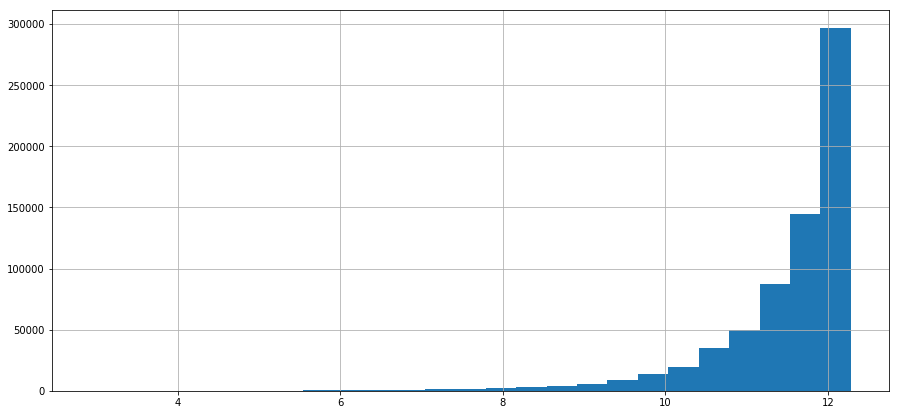

In [23]:
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(data['Snippet']))

print( "\nCreated %d X %d TF-IDF-normalized document-term matrix\n" % (vz.shape[0], vz.shape[1]) )

# create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

print( f"Printing the top 5 words from TF-IDF weighted document-term matrix \n {tfidf.head()}" )

print("\nDistribution of the tfidf scores through an histogram\n")
tfidf.tfidf.hist(bins=25, figsize=(15,7))


,Query,Snippet,tokens
0,www komfort com,glass door glazed partition available framed f...,"[glass, door, glazed, partition, available, fr..."
1,bbb,kle japanese better business bureau explanatio...,"[kle, japanese, better, business, bureau, expl..."
2,spyro reignited trilogy xbox one pre order mic...,playstation family xbox device microsoft xbox ...,"[playstation, family, xbox, device, microsoft,..."
3,northern damselfly,condition assessment common standard monitorin...,"[condition, assessment, common, standard, moni..."
4,vonhaus electric hedge trimmer cutter with ...,buy vonhaus electric hedge trimmer blade diy a...,"[buy, vonhaus, electric, hedge, trimmer, blade..."
5,huf gbp,huf hungarian forint huf british pound gbp cur...,"[huf, hungarian, forint, huf, british, pound, ..."
6,,check tavy bridge london clinic medical centre...,"[check, tavy, bridge, london, clinic, medical,..."
7,asus geforce,buy asus geforce graphic card efficient coolin...,"[buy, asus, geforce, graphic, card, efficient,..."
8,beskriv arbetsmiljlagen afs samt afs hur kan...,det kan ifrgasttas hur anpassade dessa begrepp...,"[det, kan, ifrgasttas, hur, anpassade, dessa, ..."
9,kemnay gray grannit stone chipping for garden,scottish silver granite chipping stone aquatic...,"[scottish, silver, granite, chipping, stone, a..."


In [24]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 676705 distinct terms


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [25]:
def rank_terms(vz , terms ):
    # get the sums over each column
    sums = vz.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

We can now display a ranking of the top 20 terms, which gives us a very rough sense of the content of the document collection:

In [26]:
ranking = rank_terms(vz, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. service (3103.20)
02. new (3068.46)
03. time (3013.29)
04. online (2949.75)
05. best (2900.63)
06. review (2813.63)
07. video (2792.12)
08. information (2587.89)
09. contact (2523.07)
10. day (2431.39)
11. company (2426.74)
12. house (2417.33)
13. home (2341.35)
14. photo (2324.54)
15. hotel (2285.52)
16. great (2264.99)
17. latest (2232.23)
18. price (2223.67)
19. year (2212.40)
20. sale (2207.42)


### Saving the terms document matrix

In [27]:
joblib.dump((vectorizer, vz,terms,data), "24-07-tfidf.pkl")

['24-07-tfidf.pkl']

### Most Common And Least Common Words
 We would use world clound to print these words.


Most Salient Terms In All The Documents



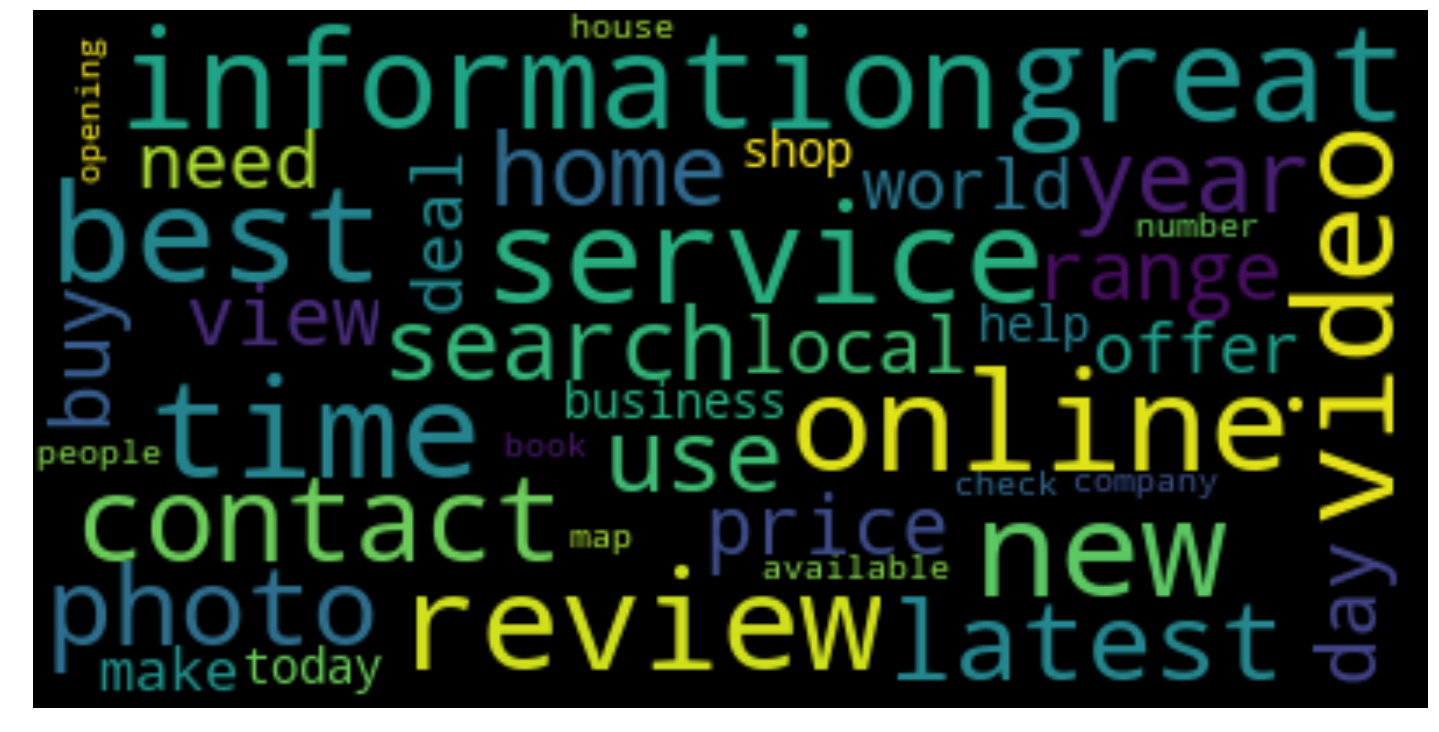


Least Common Words In All The Documents



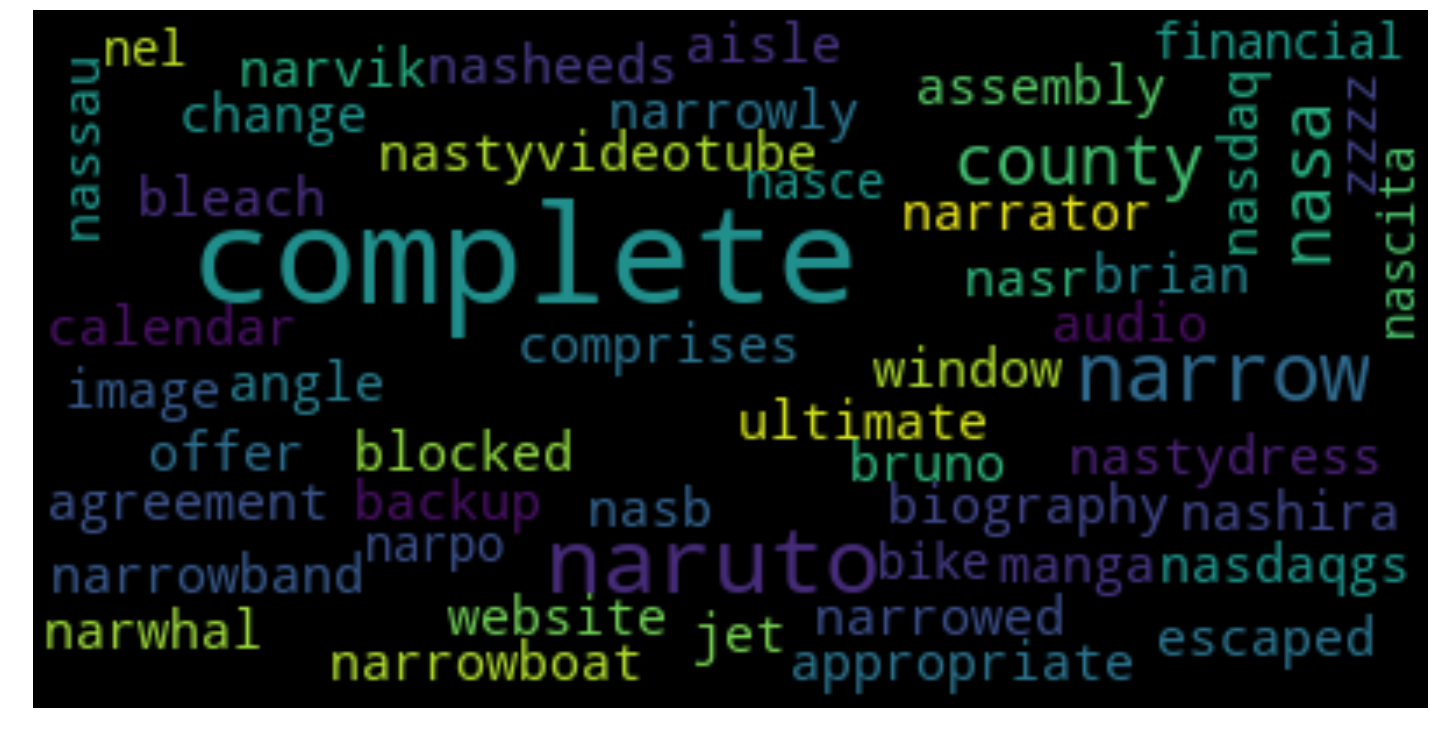

In [13]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Most common words
print("\nMost Salient Terms In All The Documents\n")
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))


# Most importa
print("\nLeast Common Words In All The Documents\n")
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

# Part 2 -  Building Topic Models and Saving the model output

Topic modelling aims to automatically discover the hidden theme in a large corpus of text documents. In our case, snippets are documents - representing the Query. We tried couple of approaches like LDA, clustering based on frequency and NMF. One approach, which we finallized for topic modelling here is **Non-Negative Matrix Factorization**.  

Let's load the tf-idf object which save in previous part.

In [3]:
(vectorizer, vz,terms,data) = joblib.load( "24-07-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (vz.shape[0], vz.shape[1]) )

Loaded 476637 X 676705 document-term matrix


# Some important parameters

1. Using SVD-based initialisation provides more reliable results. There are other choices for NMF which revolves around initialisations. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. So to get avoid this we use SVD-based initialisation. 

2. The other most important parameter is number of topics to generate. For the moment, we will pre-specify a guessed value, for tetsing purposes, setting it at 40.

Note: We did above exercise and now you may see a different K value in th below code.

In [7]:
from sklearn.decomposition import NMF

k = 100

nmf_24 = NMF(n_components = k, random_state = 1, alpha = .1, l1_ratio = .5, init = 'nndsvd', 
             verbose = True, max_iter = 100, tol=0.001)
# feature_names = vectorizer.get_feature_names()
# We have done this step in part 1 so for now taking it from that
# feature_names = terms

The violation is not the objective function.
It is the sum of the absolute value of the projected gradient, and it's used only as a stopping criterion.
The objective function is costly to compute, so it is not computed at each iteration.
It can be computed with sklearn.decomposition.nmf._beta_divergence(X, W, H, beta_loss=2).
Maybe we need a public method to compute the objective function.

In [8]:
# apply the model and extrcating the two smaller matrices
W = nmf_24.fit_transform(vz)
H = nmf_24.components_
print(f"Actual Number of Iterations: {nmf_24.n_iter_}")

violation: 1.0
violation: 0.13937871375837618
violation: 0.08459161138031396
violation: 0.0496830087165123
violation: 0.032398668340023376
violation: 0.023448136273309862
violation: 0.019128598257467475
violation: 0.016483493016843275
violation: 0.014636659948900246
violation: 0.013529286752833717
violation: 0.012336389261887364
violation: 0.010115540557006916
violation: 0.007982849096592423
violation: 0.006681064446608476
violation: 0.005701106124401776
violation: 0.004809294608218804
violation: 0.00404177995874495
violation: 0.003477803209203517
violation: 0.0031258511104895062
violation: 0.0029174886948253554
violation: 0.0028120462584144096
violation: 0.002772379515374923
violation: 0.002729428336550093
violation: 0.002605613487211651
violation: 0.0023899825767255286
violation: 0.002136285353100251
violation: 0.001937061373895106
violation: 0.0018110364845716131
violation: 0.001715047289358006
violation: 0.0016337192495038842
violation: 0.0015611519952437433
violation: 0.0014931218

### Understaing the two factor matrices

In the W factor we have weights for each document relative to each of the 40 topics. Here each row corresponds to a document, and each column corresponds to a topic. 

On the other hand, H factor contains the term weights relative to each of the k topics. Here each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [11]:
print(f'Total number of documents in original data {data.shape[0]} and total number \nof documents in the W factor {W.shape[0]}')
print(f'Total number of unqiue words in original data {len(terms)} and total number \nof documents in the W factor {H.shape[1]}')

Total number of documents in original data 476637 and total number 
of documents in the W factor 476637
Total number of unqiue words in original data 676705 and total number 
of documents in the W factor 676705


### Checking the Ouptut

Let's print the top n most imporant topics and also see the top n words which mostly describe these topics. Will also draw horizontal bar plot for specific plot to visualize the importance of words.

In [4]:
(nmf_24, W, H, terms, data) = joblib.load("24-07-tfidf-k100.pkl" )

In [9]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="orange",tick_label=top_terms)
    plt.xlabel("Term Importance - Based on Weights",fontsize=14)
    plt.tight_layout()
    plt.show()

In [10]:
no_top_words = 10
no_topics_display = 30

for topic_idx, topic in enumerate(H[:no_topics_display]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([terms[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
zzzz | fly package | fly non | fly night | fly newcastle | fly new | fly need | fly naturally | fly mile | fly midge
Topic 1:
property | house | sale | flat | house flat | property buy | house sale | property portal | largest data | driven property
Topic 2:
hotel | stay | book | best | hotel deal | deal | great | best hotel | room | hotel review
Topic 3:
weather | forecast | day | weather forecast | day weather | temperature | day forecast | day day | wind | rain
Topic 4:
porn | video | sex | porn video | tube | xxx | pornhub | xxx movie | watch | hottest
Topic 5:
opening time | opening | map | map direction | time map | photo opening | direction search | direction | contact video | video photo
Topic 6:
facebook | people | facebook connect | join facebook | know facebook | connect | facebook people | people power | power | named
Topic 7:
company | limited | company house | limited company | house | information company | registered | registered office | company information | fi

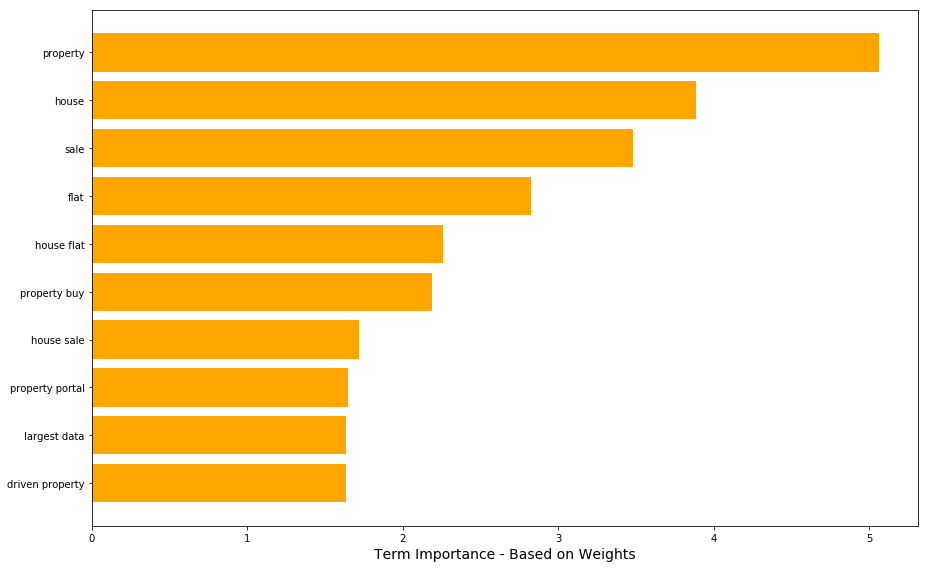

In [11]:
plot_top_term_weights( terms, H, 1, 10)

In [15]:
joblib.dump((nmf_24, W, H, terms, data), "24-07-tfidf-k%02d.pkl" % k)

['24-07-tfidf-k100.pkl']

We now create the topic table. Each column represents the topic and the rows represent 
the words which are most significant to that topic. This table is then used to analyse 
and see what percent of words repeat in each topic. Ideally, we would want each topic to 
be represented by unique set of words.

In [12]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_wordsno_top_words = 10
no_topics_display = 30

for topic_idx, topic in enumerate(H[:no_topics_display]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([terms[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]])) - 1:-1]

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = ("topic_%d:" % topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

topic_table = topic_table(nmf_24, terms, n_top_words = 10)

In [13]:
topic_table

,topic_0:,topic_10:,topic_11:,topic_12:,topic_13:,topic_14:,topic_15:,topic_16:,topic_17:,topic_18:,topic_19:,topic_1:,topic_20:,topic_21:,topic_22:,topic_23:,topic_24:,topic_25:,topic_26:,topic_27:,topic_28:,topic_29:,topic_2:,topic_30:,topic_31:,topic_32:,topic_33:,topic_34:,topic_35:,topic_36:,topic_37:,topic_38:,topic_39:,topic_3:,topic_40:,topic_41:,topic_42:,topic_43:,topic_44:,topic_45:,topic_46:,topic_47:,topic_48:,topic_49:,topic_4:,topic_50:,topic_51:,topic_52:,topic_53:,topic_54:,topic_55:,topic_56:,topic_57:,topic_58:,topic_59:,topic_5:,topic_60:,topic_61:,topic_62:,topic_63:,topic_64:,topic_65:,topic_66:,topic_67:,topic_68:,topic_69:,topic_6:,topic_70:,topic_71:,topic_72:,topic_73:,topic_74:,topic_75:,topic_76:,topic_77:,topic_78:,topic_79:,topic_7:,topic_80:,topic_81:,topic_82:,topic_83:,topic_84:,topic_85:,topic_86:,topic_87:,topic_88:,topic_89:,topic_8:,topic_90:,topic_91:,topic_92:,topic_93:,topic_94:,topic_95:,topic_96:,topic_97:,topic_98:,topic_99:,topic_9:
0,zzzz,train,school,house price,instagram,window,flight,rate,game,code,holiday,property,thesaurus,server,profile,code,stock,restaurant,dress,number,zzzz,amazon,hotel,tax,care,clue,medical,park,dog,sale,parking,club,london,weather,service,join linkedin,movie,music,data,estate,insurance,card,definition,shop,porn,english,travel,united,monthly visitor,food,bank,account,golf,ticket,office,opening time,pool,new,league,excel,tripadvisor,file,health,air,conversion,hair,facebook,year,bus,delivery,cottage,tweet,garden,iphone,review,council,postcode,company,samsung,road,time,episode,share,news,university,door,bike,cruise,job,airport,caravan,fortnite,woman,email,use,mercedes,west,test,mobile,world
1,fly package,ticket,primary,house,follower,microsoft,cheap flight,exchange,play,area code,book,house,synonym,sql,linkedin,discount,image,tripadvisor,wedding,phone,fly package,book,stay,income,home,crossword,surgery,holiday park,pet,used,street,cricket,street,forecast,customer,linkedin today,watch,song,protection,property,policy,credit,meaning,ebay,video,word,travel insurance,kingdom,estimated monthly,recipe,banking,password,golf club,event,microsoft,opening,swimming,york,football,cell,candid,open,mental,air conditioning,convert,beauty,people,old,route,range,catering,latest tweet,furniture,apple,customer,planning,information,limited,galaxy,map,time zone,season,price,breaking,course,garage,mountain,ship,apply,taxi,camping,cake,shoe,address,help,benz,north,blood,phone,cup
2,fly non,train ticket,primary school,sold,instagram photo,window window,cheap,exchange rate,online,area,beach,sale,antonym,sql server,profile linkedin,voucher,stock photo,bar,wedding dress,phone number,fly non,everyday low,book,pay,care home,crossword clue,centre,national park,puppy,dealer,street parking,football club,street london,day,customer service,today know,film,lyric,data protection,agent,cover,credit card,dictionary,deal,sex,translation,visa,united kingdom,month click,chicken,lloyd,login,course,tour,post office,map,swimming pool,new york,premier,column,candid photo,pdf,mental health,conditioning,inch,salon,facebook connect,child,timetable,buy,self,latest,garden centre,ipad,hour,council tax,map,company house,samsung galaxy,road map,zone,series,share price,latest,training,garage door,motorcycle,cruise ship,hiring,hire,campsite,birthday,men,outlook,work,mercedes benz,south,driving,mobile phone,world cup
3,fly night,trainline,date,price,post instagram,update,airline,currency,online game,country,inclusive,flat,thesaurus antonym,database,professional,discount code,photo,review,party,contact,fly night,store everyday,best,income tax,nursing,answer,hospital,national,cat,gumtree,pay,cricket club,road london,weather forecast,contact,learn working,online,album,gdpr,estate agent,travel insurance,gift,acronym,shop confidence,porn video,french,money,manchester,visitor month,delicious,barclays,sign,golf course,festival,post,map direction,water,city,premier league,formula,review candid,folder,safety,air conditioner,

In [14]:
# Same function as the previous one
topics_comparision_table = pd.DataFrame(None, index = topic_table.columns, columns = topic_table.columns)

for i in range(len(topic_table.columns)):
    for j in range(i , len(topic_table.columns)):
        
        if i == j:
            topics_comparision_table.ix[i, j] = 100
        else:
            topics_comparision_table.ix[i, j] = len(set(topic_table.iloc[:, i]).intersection(list(topic_table.iloc[:, j])))/len(topic_table.iloc[:, i])*100
            topics_comparision_table.ix[j, i] = len(set(topic_table.iloc[:, i]).intersection(list(topic_table.iloc[:, j])))/len(topic_table.iloc[:, i])*100 


C:\Users\MOSHA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


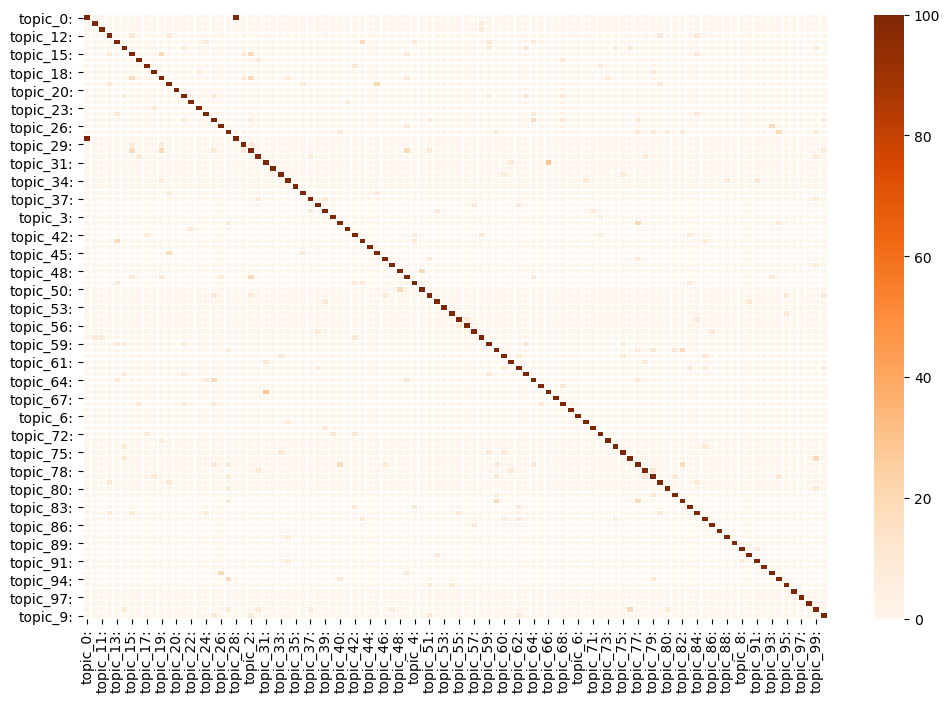

In [15]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
sns.heatmap(topics_comparision_table.fillna(0), cmap='Oranges', linewidths=0.5)

### Preparing the final output

We identify and extract the topics number assigned to each document. Then we combine and save them as a data frame. Also, before saving we take top 10 words which define the topic and add each word as part of the column. Finally the output is saved as a text file on my local system.

In [14]:
document = []
topic_most_pr = []

sme_24 = W
for n in range(sme_24.shape[0]):
    #topic_most_pr = sme[n].argmax()
    #document = n
    document.append(n)
    topic_most_pr.append(sme_24[n].argmax())

topic_out_data_24 = pd.DataFrame({'Document': document, 'Topic':topic_most_pr}, index = None)

In [17]:
# Same function as the previous one. Here we are using W directly
document = []
topic_most_pr = []
for n in range(W.shape[0]):
    #topic_most_pr = sme[n].argmax()
    #document = n
    document.append(n)
    topic_most_pr.append(W[n].argmax())

In [18]:
topic_out_data_24 = pd.DataFrame({'Document': document, 'Topic':topic_most_pr}, index = None)
topic_out_data_24_07 = pd.concat([data, topic_out_data_24, ], axis=1)

In [19]:
topic_out_data_24_07

,Query,Snippet,tokens,Document,Topic
0,www komfort com,glass door glazed partition available framed f...,"[glass, door, glazed, partition, available, fr...",0,87
1,bbb,kle japanese better business bureau explanatio...,"[kle, japanese, better, business, bureau, expl...",1,95
2,spyro reignited trilogy xbox one pre order mic...,playstation family xbox device microsoft xbox ...,"[playstation, family, xbox, device, microsoft,...",2,72
3,northern damselfly,condition assessment common standard monitorin...,"[condition, assessment, common, standard, moni...",3,24
4,vonhaus electric hedge trimmer cutter with ...,buy vonhaus electric hedge trimmer blade diy a...,"[buy, vonhaus, electric, hedge, trimmer, blade...",4,72
5,huf gbp,huf hungarian forint huf british pound gbp cur...,"[huf, hungarian, forint, huf, british, pound, ...",5,16
6,,check tavy bridge london clinic medical centre...,"[check, tavy, bridge, london, clinic, medical,...",6,39
7,asus geforce,buy asus geforce graphic card efficient coolin...,"[buy, asus, geforce, graphic, card, efficient,...",7,47
8,beskriv arbetsmiljlagen afs samt afs hur kan...,det kan ifrgasttas hur anpassade dessa begrepp...,"[det, kan, ifrgasttas, hur, anpassade, dessa, ...",8,0
9,kemnay gray grannit stone chipping for garden,scottish silver granite chipping stone aquatic...,"[scottish, silver, granite, chipping, stone, a...",9,75


In [21]:
topics_words = []
feature_names = terms
for topic_idx, topic in enumerate(H[:]):
    #print("Topic %d:"% (topic_idx))
    topics_words.append(" | ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

names =[]    
for i in range(1, 11):
    names.append("Word_"+str(i))
    
topic_Words = pd.Series(topics_words).str.split('|', 10, expand=True)
topic_Words.columns = names
topic_Words['Topic'] = topic_Words.index
topic_Words.head()

Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 5:
Topic 6:
Topic 7:
Topic 8:
Topic 9:
Topic 10:
Topic 11:
Topic 12:
Topic 13:
Topic 14:
Topic 15:
Topic 16:
Topic 17:
Topic 18:
Topic 19:
Topic 20:
Topic 21:
Topic 22:
Topic 23:
Topic 24:
Topic 25:
Topic 26:
Topic 27:
Topic 28:
Topic 29:
Topic 30:
Topic 31:
Topic 32:
Topic 33:
Topic 34:
Topic 35:
Topic 36:
Topic 37:
Topic 38:
Topic 39:
Topic 40:
Topic 41:
Topic 42:
Topic 43:
Topic 44:
Topic 45:
Topic 46:
Topic 47:
Topic 48:
Topic 49:
Topic 50:
Topic 51:
Topic 52:
Topic 53:
Topic 54:
Topic 55:
Topic 56:
Topic 57:
Topic 58:
Topic 59:
Topic 60:
Topic 61:
Topic 62:
Topic 63:
Topic 64:
Topic 65:
Topic 66:
Topic 67:
Topic 68:
Topic 69:
Topic 70:
Topic 71:
Topic 72:
Topic 73:
Topic 74:
Topic 75:
Topic 76:
Topic 77:
Topic 78:
Topic 79:
Topic 80:
Topic 81:
Topic 82:
Topic 83:
Topic 84:
Topic 85:
Topic 86:
Topic 87:
Topic 88:
Topic 89:
Topic 90:
Topic 91:
Topic 92:
Topic 93:
Topic 94:
Topic 95:
Topic 96:
Topic 97:
Topic 98:
Topic 99:


,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10,Topic
0,zzzz,fly package,fly non,fly night,fly newcastle,fly new,fly need,fly naturally,fly mile,fly midge,0
1,property,house,sale,flat,house flat,property buy,house sale,property portal,largest data,driven property,1
2,hotel,stay,book,best,hotel deal,deal,great,best hotel,room,hotel review,2
3,weather,forecast,day,weather forecast,day weather,temperature,day forecast,day day,wind,rain,3
4,porn,video,sex,porn video,tube,xxx,pornhub,xxx movie,watch,hottest,4


In [59]:

topic_out_data_24_07_final = topic_out_data_24_07.merge(topic_Words, how='left', on = 'Topic')

topic_out_data_24_07_final.to_csv(r'C:\Projects\Query\intermediate_Files\NMF\topic_out_data_24_07_final.txt', header= True, index=None, sep=' ', mode='a')

In [22]:
# Performing the above task but instead of saving the values in different columns saving them in one column.

no_top_words = 20
feature_names = terms
topics_words = []
for topic_idx, topic in enumerate(H[:]):
    #print("Topic %d:"% (topic_idx))
    topics_words.append(" | ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

    
topic_Words = pd.Series(topics_words)
topic_Words = topic_Words.to_frame(name="Top Words")
topic_Words['Topic'] = topic_Words.index

In [85]:
topic_Words = topic_Words[['Topic',"Top Words"]]

topic_out_data_24_07['Topic'] = topic_out_data_24_07['Topic'].values.astype(np.int64)
topic_Words['Topic'] = topic_Words['Topic'].values.astype(np.int64)

topic_train_1column_24_07_final = pd.merge(topic_out_data_24_07, topic_Words, on = 'Topic', how = 'left')

topic_train_1column_24_07_final = topic_train_1column_24_07_final.drop(['tokens'], axis=1)
topic_train_1column_24_07_final = topic_train_1column_24_07_final[['Document','Query', 'Snippet', 'Topic',"Top Words"]]

#joblib.dump((topic_train_1column_24_07_final), "topic_train_1column_10_07_final.pkl")

In [24]:
topic_train_1column_24_07_final

,Document,Query,Snippet,Topic,Top Words
0,0,www komfort com,glass door glazed partition available framed f...,87,door | garage | garage door | lock | upvc | gl...
1,1,bbb,kle japanese better business bureau explanatio...,95,use | help | work | make | need | way | form |...
2,2,spyro reignited trilogy xbox one pre order mic...,playstation family xbox device microsoft xbox ...,72,delivery | range | buy | online | product | da...
3,3,northern damselfly,condition assessment common standard monitorin...,24,stock | image | stock photo | photo | vector |...
4,4,vonhaus electric hedge trimmer cutter with ...,buy vonhaus electric hedge trimmer blade diy a...,72,delivery | range | buy | online | product | da...
5,5,huf gbp,huf hungarian forint huf british pound gbp cur...,16,rate | exchange | exchange rate | currency | p...
6,6,,check tavy bridge london clinic medical centre...,39,london | street | street london | road london ...
7,7,asus geforce,buy asus geforce graphic card efficient coolin...,47,card | credit | credit card | gift | debit | p...
8,8,beskriv arbetsmiljlagen afs samt afs hur kan...,det kan ifrgasttas hur anpassade dessa begrepp...,0,zzzz | fly package | fly non | fly night | fly...
9,9,kemnay gray grannit stone chipping for garden,scottish silver granite chipping stone aquatic...,75,garden | furniture | garden centre | plant | c...


In [25]:
def words_in_string(word_list, a_string):
    return set(word_list).intersection(a_string.split())

In [76]:
Score_top20 = []
Score_top10 = []
Score_top5 = []
Score_top3 = []
#Score_top1 = []
for i in range(0, len(topic_train_1column_24_07_final)):
    my_word_list = topic_train_1column_24_07_final.loc[i, "Top Words"].replace(' ','').split("|")
    a_string = topic_train_1column_24_07_final.loc[i, "Snippet"]
    Score_top20.append(round(len(words_in_string(my_word_list, a_string))/len(my_word_list)*100,1))
    Score_top10.append(round(len(words_in_string(my_word_list[0:10], a_string))/len(my_word_list[0:10])*100,1))
    Score_top5.append(round(len(words_in_string(my_word_list[0:5], a_string))/len(my_word_list[0:5])*100,1))
    Score_top3.append(round(len(words_in_string(my_word_list[0:3], a_string))/len(my_word_list[0:3])*100,1))
    #Score_top1.append(len(words_in_string(my_word_list[0], a_string))/len(my_word_list[0]))
    
Score = pd.DataFrame({'Score_top20':Score_top20, 'Score_top10':Score_top10, 'Score_top5': Score_top5, 'Score_top3': Score_top3},
                    columns = ['Score_top20', 'Score_top10','Score_top5','Score_top3'])

In [77]:
print(f"Length 20: {len(Score_top20)}\n")
print(f"Length 10: {len(Score_top10)}\n")
print(f"Length 5: {len(Score_top5)}\n")
print(f"Length 3: {len(Score_top3)}\n")
#print(f"Length 1: {len(Score_top1)}\n")
display(Score.head(20))

Length 20: 476637

Length 10: 476637

Length 5: 476637

Length 3: 476637



,Score_top20,Score_top10,Score_top5,Score_top3
0,20.0,30.0,20.0,33.3
1,5.0,10.0,20.0,33.3
2,15.0,20.0,20.0,0.0
3,25.0,50.0,60.0,66.7
4,40.0,50.0,80.0,100.0
5,65.0,80.0,80.0,66.7
6,25.0,30.0,40.0,66.7
7,5.0,10.0,20.0,33.3
8,0.0,0.0,0.0,0.0
9,10.0,20.0,20.0,33.3


In [105]:
topic_train_final_24_10 = pd.concat([topic_train_1column_24_07_final, Score], axis = 1)
topic_train_final_24_10 = topic_train_final_24_10.drop("Document", 1)
topic_train_final_24_10.head()

,Query,Snippet,Topic,Top Words,Score_top20,Score_top10,Score_top5,Score_top3
0,www komfort com,glass door glazed partition available framed f...,87,door | garage | garage door | lock | upvc | gl...,20.0,30.0,20.0,33.3
1,bbb,kle japanese better business bureau explanatio...,95,use | help | work | make | need | way | form |...,5.0,10.0,20.0,33.3
2,spyro reignited trilogy xbox one pre order mic...,playstation family xbox device microsoft xbox ...,72,delivery | range | buy | online | product | da...,15.0,20.0,20.0,0.0
3,northern damselfly,condition assessment common standard monitorin...,24,stock | image | stock photo | photo | vector |...,25.0,50.0,60.0,66.7
4,vonhaus electric hedge trimmer cutter with ...,buy vonhaus electric hedge trimmer blade diy a...,72,delivery | range | buy | online | product | da...,40.0,50.0,80.0,100.0


In [132]:
for i in range(0, 100):    
    check = topic_train_final_24_10[topic_train_final_24_10.Topic == i]
    if check.shape[0] != 0:
    #display(check.head(10))
        print(f"% of corpus belonging to topic {i} : {check.shape[0]}")
        print(f"% of corpus where more than 50% Matched Top3: {len(check[check.Score_top3 >= 50.0])/check.shape[0]}")
        print(f"% of corpus where more than 50% Matched Top5: {len(check[check.Score_top5 >= 50.0])/check.shape[0]}")
        print(f"% of corpus where more than 40% Matched Top10: {len(check[check.Score_top10 >= 40.0])/check.shape[0]}")
    else:
        pass

% of corpus belonging to topic 0 : 1412
% of corpus where more than 50% Matched Top3: 0.0
% of corpus where more than 50% Matched Top5: 0.0
% of corpus where more than 40% Matched Top10: 0.0
% of corpus belonging to topic 1 : 4282
% of corpus where more than 50% Matched Top3: 0.9182624941616068
% of corpus where more than 50% Matched Top5: 0.8439981317141523
% of corpus where more than 40% Matched Top10: 0.6398879028491359
% of corpus belonging to topic 2 : 5970
% of corpus where more than 50% Matched Top3: 0.716247906197655
% of corpus where more than 50% Matched Top5: 0.4644891122278057
% of corpus where more than 40% Matched Top10: 0.6045226130653266
% of corpus belonging to topic 3 : 4416
% of corpus where more than 50% Matched Top3: 0.740036231884058
% of corpus where more than 50% Matched Top5: 0.6286231884057971
% of corpus where more than 40% Matched Top10: 0.48165760869565216
% of corpus belonging to topic 4 : 9666
% of corpus where more than 50% Matched Top3: 0.83426443202979

% of corpus where more than 40% Matched Top10: 0.10706264037933616
% of corpus belonging to topic 71 : 2661
% of corpus where more than 50% Matched Top3: 0.43855693348365277
% of corpus where more than 50% Matched Top5: 0.24577226606538896
% of corpus where more than 40% Matched Top10: 0.17098835024426906
% of corpus belonging to topic 72 : 14617
% of corpus where more than 50% Matched Top3: 0.4963398782239858
% of corpus where more than 50% Matched Top5: 0.4494082233016351
% of corpus where more than 40% Matched Top10: 0.42347951015940344
% of corpus belonging to topic 73 : 2712
% of corpus where more than 50% Matched Top3: 0.49004424778761063
% of corpus where more than 50% Matched Top5: 0.3329646017699115
% of corpus where more than 40% Matched Top10: 0.4391592920353982
% of corpus belonging to topic 74 : 5040
% of corpus where more than 50% Matched Top3: 0.9501984126984127
% of corpus where more than 50% Matched Top5: 0.19940476190476192
% of corpus where more than 40% Matched Top1

In [56]:
print(f"Total rows in the dataset: {topic_train_1column_24_07_final.shape[0]}\n")
print(f"Number of queries where 70% of first 10 words were present {len(topic_train_1column_24_07_final[topic_train_1column_24_07_final.Topic == 4])}")


print(f"\nPriting top 5 rows: {topic_train_1column_24_07_final}")

Total rows in the dataset: 476637

Number of queries where 70% of first 10 words were present 9666

Priting top 5 rows:         Document                                              Query  \
348          348                                    jebel ali hotel   
414          414                          ocean beach hotel and spa   
461          461                                  sekysen shah alam   
645          645                                bride hotel and spa   
928          928              hall   telford and wrekin for   party   
930          930                          hallmark hotel king cross   
966          966                                    hotel liverpool   
967          967                                  hotel near hagley   
1066        1066                                           kalamata   
1082        1082                                           koh lipe   
1095        1095                     vega famous attraction for kid   
1127        1127            

[5970 rows x 7 columns]


# Part 3 -  Figuring out optimal number of Topics

We would now like to see what is the optimal number of topics as in part two we just passed some random like 40. To achieve this task we gonna compare and meausre the topic coherence of models generated with different K values.
To start with we will start with the range of 35 to 100 topics. 

In [176]:
    k_min, k_max =  35, 200

We are going to build the model for all the values increasing the value by 5 everytime. This means that we will build the model for 35, 40, 45 and so on. 

In [177]:
topic_models = []

for k in range(k_min,k_max + 1, 5):
    print("Building NMF Model for k = %d ..." % k)
    # run NMF
    model = NMF(n_components = k, random_state = 1, alpha = .1, l1_ratio = .5, init = 'nndsvd', verbose = False)
    W = model.fit_transform( vz )
    H = model.components_    
    # store for later
    topic_models.append((k,W,H))

Building NMF Model for k = 35 ...
Building NMF Model for k = 40 ...
Building NMF Model for k = 45 ...
Building NMF Model for k = 50 ...
Building NMF Model for k = 55 ...
Building NMF Model for k = 60 ...
Building NMF Model for k = 65 ...
Building NMF Model for k = 70 ...
Building NMF Model for k = 75 ...
Building NMF Model for k = 80 ...
Building NMF Model for k = 85 ...
Building NMF Model for k = 90 ...
Building NMF Model for k = 95 ...
Building NMF Model for k = 100 ...
Building NMF Model for k = 105 ...
Building NMF Model for k = 110 ...
Building NMF Model for k = 115 ...
Building NMF Model for k = 120 ...
Building NMF Model for k = 125 ...
Building NMF Model for k = 130 ...
Building NMF Model for k = 135 ...
Building NMF Model for k = 140 ...
Building NMF Model for k = 145 ...
Building NMF Model for k = 150 ...
Building NMF Model for k = 155 ...
Building NMF Model for k = 160 ...
Building NMF Model for k = 165 ...
Building NMF Model for k = 170 ...
Building NMF Model for k = 175 ..

To select the number of topics, we are using topic coherence measure called TC-W2V.  This model requires us to have word2vec model, We now have to build our own word2vec model from the current douments courpus.

Let's read the snippets again inorder to train our own word2vec model.

In [178]:
print("We have %d raw snippets\n" % len(data))
print("Using the pre-built gensim model to generate coherence scores\n")
# w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
# Parking this pre-model for now as some of the words are not found in it.

We have 476637 raw snippets

Using the pre-built gensim model to generate coherence scores



In [128]:

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2))
analyzer = vectorizer.build_analyzer()

data["Uni_Bi_Gram_Tokens"] = data.loc[: , "Snippet"].apply(lambda x : analyzer(x))

0    [glass, door, glazed, partition, available, fr...
Name: Uni_Bi_Gram_Tokens, dtype: object

In [132]:
#documentgen = TokenGenerator(data.loc[: , "Snippet"], stop_words_list )
# the model has 500 dimensions, the minimum document-term frequency is 5
w2v_model = gensim.models.Word2Vec(data.loc[: , "Uni_Bi_Gram_Tokens"], size=19439, min_count= 5, sg=1, seed = 101)

In [133]:
print( "Total number of terms in model are %d" % len(w2v_model.wv.vocab) )
print( "Saving the model..\n")
w2v_model.save("w2v-model.bin")

Total number of terms in model are 836688
Saving the model..



In [87]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [179]:
from  itertools  import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\MOSHA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=35: Coherence=0.4354
K=40: Coherence=0.4327
K=45: Coherence=0.4268
K=50: Coherence=0.4301
K=55: Coherence=0.4301
K=60: Coherence=0.4347
K=65: Coherence=0.4360
K=70: Coherence=0.4323
K=75: Coherence=0.4373
K=80: Coherence=0.4351
K=85: Coherence=0.4324
K=90: Coherence=0.4331
K=95: Coherence=0.4308
K=100: Coherence=0.4372
K=105: Coherence=0.4402
K=110: Coherence=0.4345
K=115: Coherence=0.4391
K=120: Coherence=0.4477
K=125: Coherence=0.4385
K=130: Coherence=0.4450
K=135: Coherence=0.4435
K=140: Coherence=0.4486
K=145: Coherence=0.4492
K=150: Coherence=0.4519
K=155: Coherence=0.4569
K=160: Coherence=0.4498
K=165: Coherence=0.4699
K=170: Coherence=0.4661
K=175: Coherence=0.4704
K=180: Coherence=0.4683
K=185: Coherence=0.4781
K=190: Coherence=0.4901
K=195: Coherence=0.4843
K=200: Coherence=0.4934


In [184]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 20})

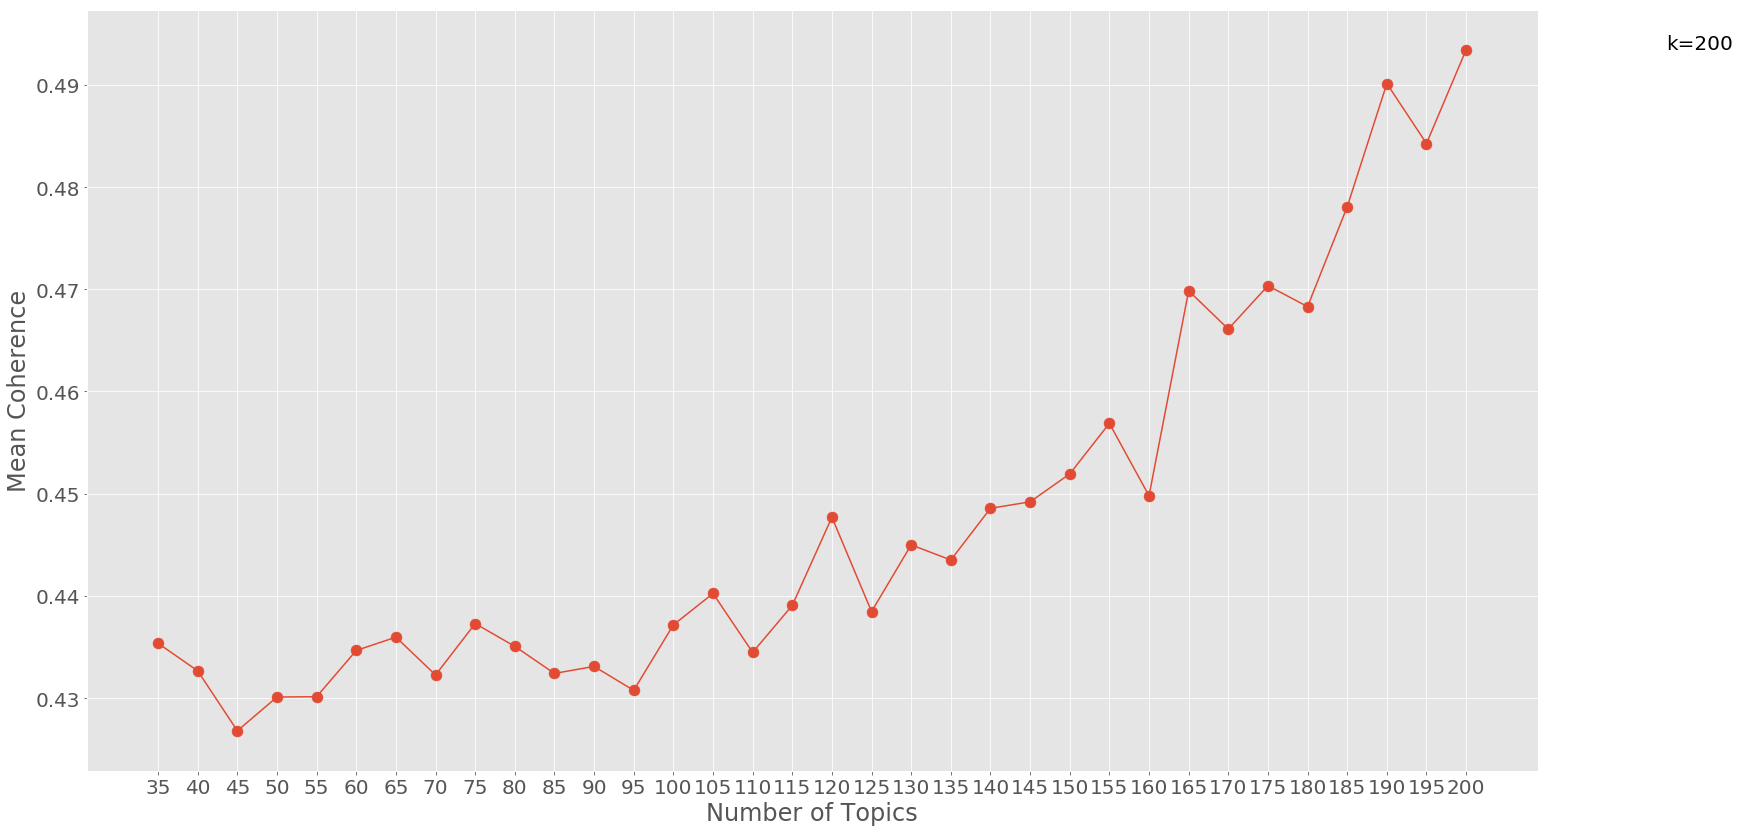

In [185]:
fig = plt.figure(figsize=(16,10))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=20)
# show the plot
plt.show()

In [454]:
from sklearn.decomposition import NMF

k = 105

nmf_24 = NMF(n_components = k, random_state = 1, alpha = .1, l1_ratio = .5, init = 'nndsvd', verbose = True)


In [443]:
# apply the model and extrcating the two smaller matrices
W = nmf_24.fit_transform(vz)
H = nmf_24.components_

print(f'Total number of documents in original data {data.shape[0]} and total number \nof documents in the W factor {W.shape[0]}')
print(f'Total number of unqiue words in original data {len(terms)} and total number \nof documents in the W factor {H.shape[1]}')

violation: 1.0
violation: 0.035733668342291774
violation: 0.016633789159161715
violation: 0.011424960368997072
violation: 0.00862113066448634
violation: 0.006474097499474317
violation: 0.005131052924262347
violation: 0.004377192671663693
violation: 0.00364823186872935
violation: 0.0029794952168500826
violation: 0.0024117143001921464
violation: 0.001816662852958313
violation: 0.0013878090024593366
violation: 0.0010803556543371783
violation: 0.0008274880152018869
violation: 0.0006523466084771352
violation: 0.0005169085787877673
violation: 0.00042361321912458505
violation: 0.0003585338683728597
violation: 0.00031039184139539105
violation: 0.00027732887992085707
violation: 0.0002533628131172754
violation: 0.0002354355117551888
violation: 0.00022281632933694352
violation: 0.0002143236726773305
violation: 0.0002094767176789214
violation: 0.0002084085547544172
violation: 0.00021169843786475828
violation: 0.00022050582148319453
violation: 0.00023840993324565906
violation: 0.0002632111141974356

In [377]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [444]:
no_top_words = 10
no_topics_display = 20

for topic_idx, topic in enumerate(H[:no_topics_display]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([terms[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
zoopla | extra | fabric | face | facebook | facility | fact | fact popularity | factor | fake
Topic 1:
house | property | house price | sold | price | sale | sold house | postcode | rightmove | checker tool
Topic 2:
porn | video | movie | sex | tube | porn video | xxx | watch | hottest | collection
Topic 3:
film | cinema | movie | hit | leeds | day | action | comedy | digital | time
Topic 4:
opening | contact | service | opening time | direction | time | search | local | map | review
Topic 5:
zoopla | extra | fabric | face | facebook | facility | fact | fact popularity | factor | fake
Topic 6:
instagram photo | post instagram | follower post | post | follower | instagram | photo video | photo | video | close
Topic 7:
english | translation | dictionary | english translation | example | french | word | german | phrase | sentence
Topic 8:
job | apply | job site | hiring | site | world largest | job hiring | largest job | charity | largest
Topic 9:
zoopla | extra | fabric | face |

In the snippet above we get a first glimpse about the topics found. Honestly, we don't always find the top words useful when used alone. Thus looking in which Snippets the topics are "activated" the most. We therefore transform the tfidf-matrix into the nmf-embedding and have a look with np.argsort, which snippets have the strongest link to each topic.

In [5]:
nmf_embedding = nmf_24.transform(vz)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

violation: 1.0
violation: 0.20615182175569208
violation: 0.007377896917366611
violation: 0.000608456456758001
violation: 5.555074580604795e-05
Converged at iteration 5


C:\Users\MOSHA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [26]:
np.argsort(nmf_embedding[0],axis=0)

array([70, 61, 97, 82, 36,  5, 49, 58, 74, 27, 52, 43, 39, 81, 33, 79, 93,
       85, 64, 54,  7, 31, 56, 25, 94,  2, 29,  1, 44, 17,  4, 19, 14,  8,
       42, 99, 34, 51, 78, 11, 50, 45,  6, 62, 13, 41, 48, 75, 38, 83, 12,
       98, 18, 86, 65, 22, 47, 30,  3, 90, 24, 60, 68,  9, 15, 73, 35, 23,
       63, 67, 71, 26, 46, 16, 53, 69, 37, 92, 91, 76, 21, 88, 57, 20, 32,
       89, 80, 55, 96, 10, 40, 77, 84, 95, 72, 66, 59, 87, 28,  0],
      dtype=int64)

In [44]:
nmf_embedding.T

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.15743633, -0.15743633, -0.15743633, ..., -0.15743633,
        -0.15743633, -0.15743633],
       [-0.16062186, -0.16062186, -0.16062186, ..., -0.16062186,
        -0.16062186, -0.16062186],
       ...,
       [-0.27706479, -0.27706479, -0.27706479, ..., -0.27706479,
        -0.27706479, -0.27706479],
       [-0.12050103, -0.12050103, -0.12050103, ..., -0.12050103,
        -0.12050103, -0.12050103],
       [-0.14710245, -0.14710245, -0.14710245, ...,  0.33724382,
        -0.14710245, -0.01280629]])

In [42]:
x = np.array([[8, 3], [2, 4]])
np.argsort(x, axis = 0)

array([[1, 0],
       [0, 1]], dtype=int64)

In [14]:

top_idx = np.argsort(nmf_embedding,axis=0)[-3:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(data.iloc[idx][['Query','Snippet']])
    count += 1


Topic 0:

Topic 1:

Topic 2:

Topic 3:

Topic 4:

Topic 5:

Topic 6:

Topic 7:

Topic 8:

Topic 9:

Topic 10:

Topic 11:

Topic 12:

Topic 13:

Topic 14:

Topic 15:

Topic 16:

Topic 17:

Topic 18:

Topic 19:

Topic 20:

Topic 21:

Topic 22:

Topic 23:

Topic 24:

Topic 25:

Topic 26:

Topic 27:

Topic 28:

Topic 29:

Topic 30:

Topic 31:

Topic 32:

Topic 33:

Topic 34:

Topic 35:

Topic 36:

Topic 37:

Topic 38:

Topic 39:

Topic 40:

Topic 41:

Topic 42:

Topic 43:

Topic 44:

Topic 45:

Topic 46:

Topic 47:

Topic 48:

Topic 49:

Topic 50:

Topic 51:

Topic 52:

Topic 53:

Topic 54:

Topic 55:

Topic 56:

Topic 57:

Topic 58:

Topic 59:

Topic 60:

Topic 61:

Topic 62:

Topic 63:

Topic 64:

Topic 65:

Topic 66:

Topic 67:

Topic 68:

Topic 69:

Topic 70:

Topic 71:

Topic 72:

Topic 73:

Topic 74:

Topic 75:

Topic 76:

Topic 77:

Topic 78:

Topic 79:

Topic 80:

Topic 81:

Topic 82:

Topic 83:

Topic 84:

Topic 85:

Topic 86:

Topic 87:

Topic 88:

Topic 89:

Topic 90:

Topic 91

We now create the topic table. Each column represents the topic and the rows represent the words which are most significant to that topic. This table is then used to analyse and see what percent of words repeat in each topic. Ideally, we would want each topic to be represented by unique set of words.

In [ ]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = ("topic_%d:" % topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

topic_table = topic_table(nmf_24, terms, n_top_words = 10)

,topic_0:,topic_100:,topic_101:,topic_102:,topic_103:,topic_104:,topic_10:,topic_11:,topic_12:,topic_13:,topic_14:,topic_15:,topic_16:,topic_17:,topic_18:,topic_19:,topic_1:,topic_20:,topic_21:,topic_22:,topic_23:,topic_24:,topic_25:,topic_26:,topic_27:,topic_28:,topic_29:,topic_2:,topic_30:,topic_31:,topic_32:,topic_33:,topic_34:,topic_35:,topic_36:,topic_37:,topic_38:,topic_39:,topic_3:,topic_40:,topic_41:,topic_42:,topic_43:,topic_44:,topic_45:,topic_46:,topic_47:,topic_48:,topic_49:,topic_4:,topic_50:,topic_51:,topic_52:,topic_53:,topic_54:,topic_55:,topic_56:,topic_57:,topic_58:,topic_59:,topic_5:,topic_60:,topic_61:,topic_62:,topic_63:,topic_64:,topic_65:,topic_66:,topic_67:,topic_68:,topic_69:,topic_6:,topic_70:,topic_71:,topic_72:,topic_73:,topic_74:,topic_75:,topic_76:,topic_77:,topic_78:,topic_79:,topic_7:,topic_80:,topic_81:,topic_82:,topic_83:,topic_84:,topic_85:,topic_86:,topic_87:,topic_88:,topic_89:,topic_8:,topic_90:,topic_91:,topic_92:,topic_93:,topic_94:,topic_95:,topic_96:,topic_97:,topic_98:,topic_99:,topic_9:
0,zzzz,cruise,manchester,review,mercedes,salary,train,school,house price,instagram,window,flight,rate,game,code,holiday,property,definition,company,profile,code,stock,restaurant,woman,number,zzzz,amazon,hotel,tax,care,clue,tripadvisor,email,dog,sale,parking,club,london,weather,cinema,join linkedin,movie,song,excel,property,insurance,card,thesaurus,travel,porn,heard,pension,english,united,shop,mobile,bank,golf,ticket,file,opening time,pool,park,league,office,pain,hire,health,business,conversion,new,facebook,day,news,hair,medical,tweet,bus,samsung,service,airport,iphone,company,time,garden,road,air,child,year,bike,radio,council,ireland,job,episode,door,court,university,water,test,word,cake,dress,server,world
1,fly package,ship,greater manchester,hour,benz,employee,ticket,primary,house,follower,microsoft,cheap flight,exchange,play,area code,cottage,house,meaning,limited,linkedin,discount,stock photo,food,shoe,phone,fly package,buy,stay,income,home,crossword,candid,account,pet,used,street,cricket,street,forecast,film,linkedin today,watch,music,cell,estate,policy,credit,synonym,travel insurance,video,quote,scheme,translation,kingdom,ebay,phone,banking,golf club,event,open,map,swimming,caravan,football,microsoft,cause,van,mental,directory,convert,use,people,week,latest,beauty,centre,latest tweet,route,galaxy,customer,taxi,apple,registered office,time zone,furniture,map,air conditioning,family,old,mountain,bbc,housing,northern,apply,season,garage,law,course,bottle,driving,letter,birthday,wedding,sql,cup
2,fly non,cruise ship,manchester united,opening hour,mercedes benz,review,train ticket,primary school,price,instagram photo,window window,cheap,exchange rate,online,area,book,sale,dictionary,limited company,profile linkedin,voucher,image,tripadvisor,men,phone number,fly non,delivery,book,pay,care home,crossword clue,candid photo,password,puppy,dealer,park,football club,street london,weather forecast,odeon,today know,online,lyric,data,agent,cover,credit card,antonym,visa,sex,seen heard,state pension,french,united kingdom,deal,mobile phone,account,course,tour,pdf,map direction,swimming pool,camping,premier,post office,effect,rental,mental health,business directory,inch,make,facebook connect,delivery,breaking,salon,surgery,latest,timetable,samsung galaxy,customer service,transfer,ipad,information company,zone,garden centre,postcode,conditioning,kid,year old,motorcycle,station,planning,northern ireland,hiring,series,garage door,solicitor,training,pump,blood,document,fortnite,wedding dress,sql server,world cup
3,fly night,river,greater,opening,class,posted,trainline,date,sold,post instagram,update,airline,currency,xbox,country,self catering,flat,acronym,contact,professional,discount code,photo,review,shop,address,fly night,book,best,income tax,nursing,answer,review candid,login,cat,gumtree,street parking,cricket club,road london,day,vue,learn working,movie online,album,column,estate agent,travel insurance,gift,the

In [317]:
topic_table.to_csv(r'C:\Projects\Query\intermediate_Files\NMF\topic_table_' + str(k)+ '.csv', header= True, index=None, sep=',', mode='a')

In [318]:
# Checking if the number of topics over lap between the topics - this one if for excel output
topic_1 = []
topic_2 = []
common_ratio = []

for i in range(len(topic_table.columns)):
    for j in range(i , len(topic_table.columns)):
        topic_1.append(i)
        topic_2.append(j)
        if i == j:
            common_ratio.append(100)
        else:
            common_ratio_value =len(set(topic_table.iloc[:, i]).intersection(list(topic_table.iloc[:, j])))/len(topic_table.iloc[:, i])*100
            common_ratio.append(common_ratio_value)
        
topics_comparision_table = pd.DataFrame({'topic_1': topic_1, 'topic_2' : topic_2, 'common_ratio' : common_ratio})

In [445]:
# Same function as the previous one -checking the number of topics over lap - thisone if for heatmap
topics_comparision_table = pd.DataFrame(None, index = topic_table.columns, columns = topic_table.columns)

for i in range(len(topic_table.columns)):
    for j in range(i , len(topic_table.columns)):
        
        if i == j:
            topics_comparision_table.ix[i, j] = 100
        else:
            topics_comparision_table.ix[i, j] = len(set(topic_table.iloc[:, i]).intersection(list(topic_table.iloc[:, j])))/len(topic_table.iloc[:, i])*100
            topics_comparision_table.ix[j, i] = len(set(topic_table.iloc[:, i]).intersection(list(topic_table.iloc[:, j])))/len(topic_table.iloc[:, i])*100 


AttributeError: 'function' object has no attribute 'columns'

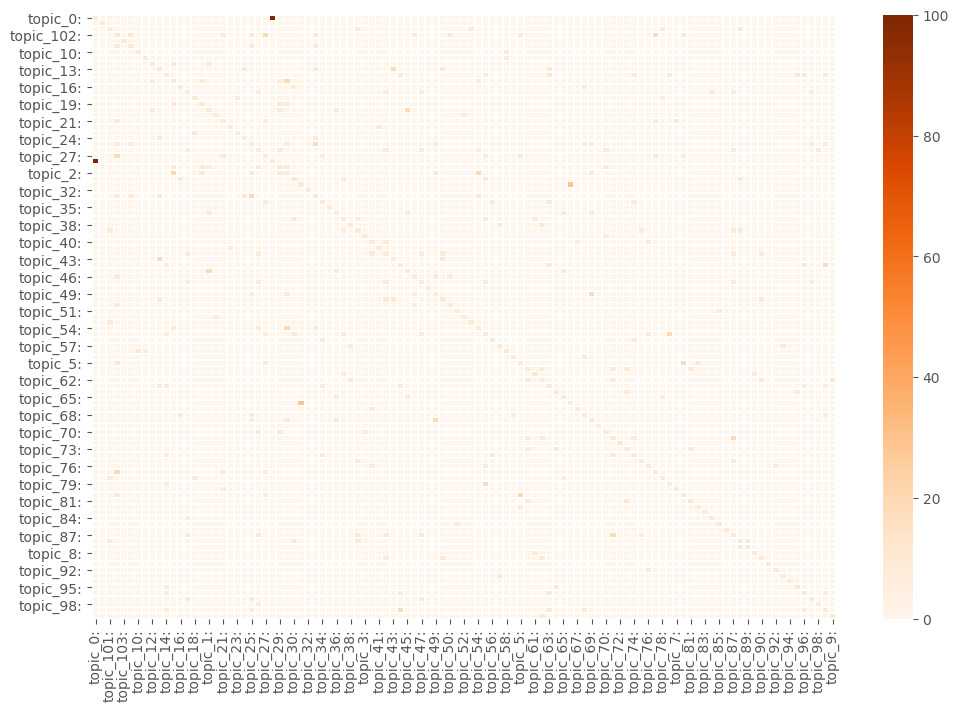

In [441]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
sns.heatmap(topics_comparision_table.fillna(0), cmap='Oranges', linewidths=0.5)

In [319]:
topics_comparision_table.to_csv(r'C:\Projects\Query\intermediate_Files\NMF\topic_out_' + str(k) +'_comparision_table.csv', header= True, index=None, sep=',', mode='a')

In [192]:
document = []
topic_most_pr = []

sme_24 = nmf_24.transform(vz)
for n in range(sme_24.shape[0]):
    #topic_most_pr = sme[n].argmax()
    #document = n
    document.append(n)
    topic_most_pr.append(sme_24[n].argmax())

topic_out_data_24 = pd.DataFrame({'Document': document, 'Topic':topic_most_pr}, index = None)

violation: 1.0
violation: 0.18421976081555175
violation: 0.006675482004848941
violation: 0.0005285457873913097
violation: 5.6295514265802274e-05
Converged at iteration 5


In [193]:
document = []
topic_most_pr1 = []
for n in range(W.shape[0]):
    #topic_most_pr = sme[n].argmax()
    #document = n
    document.append(n)
    topic_most_pr1.append(W[n].argmax())

In [194]:
topic_out_data_24 = pd.DataFrame({'Document': document, 'Topic':topic_most_pr}, index = None)
topic_out_data_24_07 = pd.concat([data, topic_out_data_24, ], axis=1)

In [195]:
topics_words = []
for topic_idx, topic in enumerate(H[:no_topics_display]):
    print("Topic %d:"% (topic_idx))
    topics_words.append(" | ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

names =[]    
for i in range(1, 11):
    names.append("Word_"+str(i))
    
topic_Words = pd.Series(topics_words).str.split('|', 10, expand=True)
topic_Words.columns = names

Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 5:
Topic 6:
Topic 7:
Topic 8:
Topic 9:
Topic 10:
Topic 11:
Topic 12:
Topic 13:
Topic 14:
Topic 15:
Topic 16:
Topic 17:
Topic 18:
Topic 19:


In [197]:
topic_Words['Topic'] = topic_Words.index

topic_out_data_24_07_final = topic_out_data_24_07.merge(topic_Words, how='inner', on = 'Topic')

topic_out_data_24_07_final.to_csv(r'C:\Projects\Query\intermediate_Files\NMF\topic_out_200_data_24_07_final.txt', header= True, index=None, sep=' ', mode='a')

In [356]:
# Testing

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2))
vz_test_10_07 = vectorizer.fit_transform(list(data.ix[: 1000, 'Snippet']))



In [366]:
nmf_24.fit_transform(vz)

<1001x1852 sparse matrix of type '<class 'numpy.float64'>'
	with 25122 stored elements in Compressed Sparse Row format>

In [458]:
text = "The economy is working better than ever"
compo = nmf_24.transform(vectorizer.transform(list(data['Snippet'])))
y = nmf_24.components_

MemoryError: 

In [449]:
compo = np.argsort(nmf_new_feedback)[-10:][::-1]
    # Connection between indices and words of tfidf
    feature_names = vectorizer.get_feature_names()
    for topic_idx in compo:
        # Current nmf topic
        topic = nmf.components_[topic_idx]
        print("Topic number: ", topic_idx)
        print("Topic score: ", nmf_new_feedback[topic_idx]/sum(nmf_new_feedback))
        # Top 15 words of current topic
        for k in topic.argsort()[-15:][::-1]
            print("Word: ",feature_names[k], "  Score: ", topic[k]/ sum(topic))

,Query,Snippet,tokens
0,,fffft ccc obj endobj obj stream tmo rjac kkkk llf,"[fffft, ccc, obj, endobj, obj, stream, tmo, rj..."
1,google,google llc american multinational technology c...,"[google, llc, american, multinational, technol..."
2,soft leather case sony dsc hxv,result sony dsc hxv case megagear leather came...,"[result, sony, dsc, hxv, case, megagear, leath..."
3,whiskmethod cake example,recipe whisked sponge cake method ingredient r...,"[recipe, whisked, sponge, cake, method, ingred..."
4,myspace,summer having spent best decade building newsp...,"[summer, having, spent, best, decade, building..."


In [451]:
no_top_words = 10
no_topics_display = 20

for topic_idx, topic in enumerate(y[:no_topics_display]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([terms[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
zoopla | extra | fabric | face | facebook | facility | fact | fact popularity | factor | fake
Topic 1:
house | property | house price | sold | price | sale | sold house | postcode | rightmove | checker tool
Topic 2:
porn | video | movie | sex | tube | porn video | xxx | watch | hottest | collection
Topic 3:
film | cinema | movie | hit | leeds | day | action | comedy | digital | time
Topic 4:
opening | contact | service | opening time | direction | time | search | local | map | review
Topic 5:
zoopla | extra | fabric | face | facebook | facility | fact | fact popularity | factor | fake
Topic 6:
instagram photo | post instagram | follower post | post | follower | instagram | photo video | photo | video | close
Topic 7:
english | translation | dictionary | english translation | example | french | word | german | phrase | sentence
Topic 8:
job | apply | job site | hiring | site | world largest | job hiring | largest job | charity | largest
Topic 9:
zoopla | extra | fabric | face |

In [453]:
k = 105